# JUMP Cell Dataset Denoising using Noise2Void

Il seguente Notebook descrive, passo per passo, l'addestramento e il testing di una Rete Neurale U-Net per la Riduzione del Rumore da immagini tratte dal [Dataset JUMP](https://github.com/jump-cellpainting/datasets).  
La Rete Neurale applica l'Algoritmo Noise2Void, la cui implementazione è resa disponibile dalla libreria [CAREamics](https://careamics.github.io/0.1/), per estrarre immagini pulite senza necessità di alcuna Ground Truth.

Obiettivo della nostra attività è comprendere le potenzialità delle Deep Neural Networks nell'ambito del Denoising, confrontare i loro risultati con quelli ottenuti tramite metodi di denoising tradizionali e imparare a conoscere l'Algoritmo N2V nei suoi dettagli.

Il Dataset JUMP offre un'interessante prospettiva poiché costituito da immagini microscopiche mediche, per cui avere una Ground Truth è impossibile con gli strumenti attuali.  
In questo contesto Noise2Void diventa lo strumento ideale per caratteristiche e prestazioni.

A tal merito è stata anche imbandita una [Grand Challenge](https://ai4life-mdc24.grand-challenge.org/ai4life-mdc24/) da parte della fondazione AI4Life.

![Grand Challenge Banner](https://rumc-gcorg-p-public.s3.amazonaws.com/b/756/denoising.x10.jpeg)

## Download the Dataset

Il Dataset viene scaricato in formato .TIFF Hyperstack dalla piattaforma Zenodo.  
Contiene 517 immagini rappresentate su 4 canali, per un totale di 2068 immagini di dimensioni 540x540 pixel.

I 4 canali rappresentano le immagini separando RGB e Alpha. Nel contesto della visualizzazione cellulare, ciò consente di distinguere con maggior precisione le parti della cellula e le loro colorazioni.

Dopo aver scaricato il Dataset, questo viene suddiviso in Training Data e Validation Data:
* I Dati di Training consentono alla Rete Neurale di apprendere i valori migliori per i suoi parametri.
* I Dati di Validation consentono di valutare l'andamento dell'addestramento per evitare potenziale overfitting.

Scegliamo uno ```split_ratio=0.8``` per indicare che l'80% delle immagini faranno parte del Training Data, mentre il 20% rimanente sarà Validation Data.

In [2]:
import tifffile
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr

sys.path.append('library')

import library.dataset as dataset

In [5]:

#Download the Dataset
#await dataset.load_jump_dataset("notebooks/data/jump/noisy.tiff")

#Split the Dataset into Training and Validation
dataset.split_jump_dataset("notebooks/data/jump/noisy.tiff", split_ratio=0.8)

Dataset size is 517
Split the dataset at index 413/517
Train dataset saved to notebooks/data/jump/noisy_train.tiff
Validation dataset saved to notebooks/data/jump/noisy_val.tiff


## Visualize the Dataset

Visualizziamo alcune immagini del Dataset a scopo illustrativo.  
Per ogni immagine, sono mostrati i 4 canali che la descrivono.

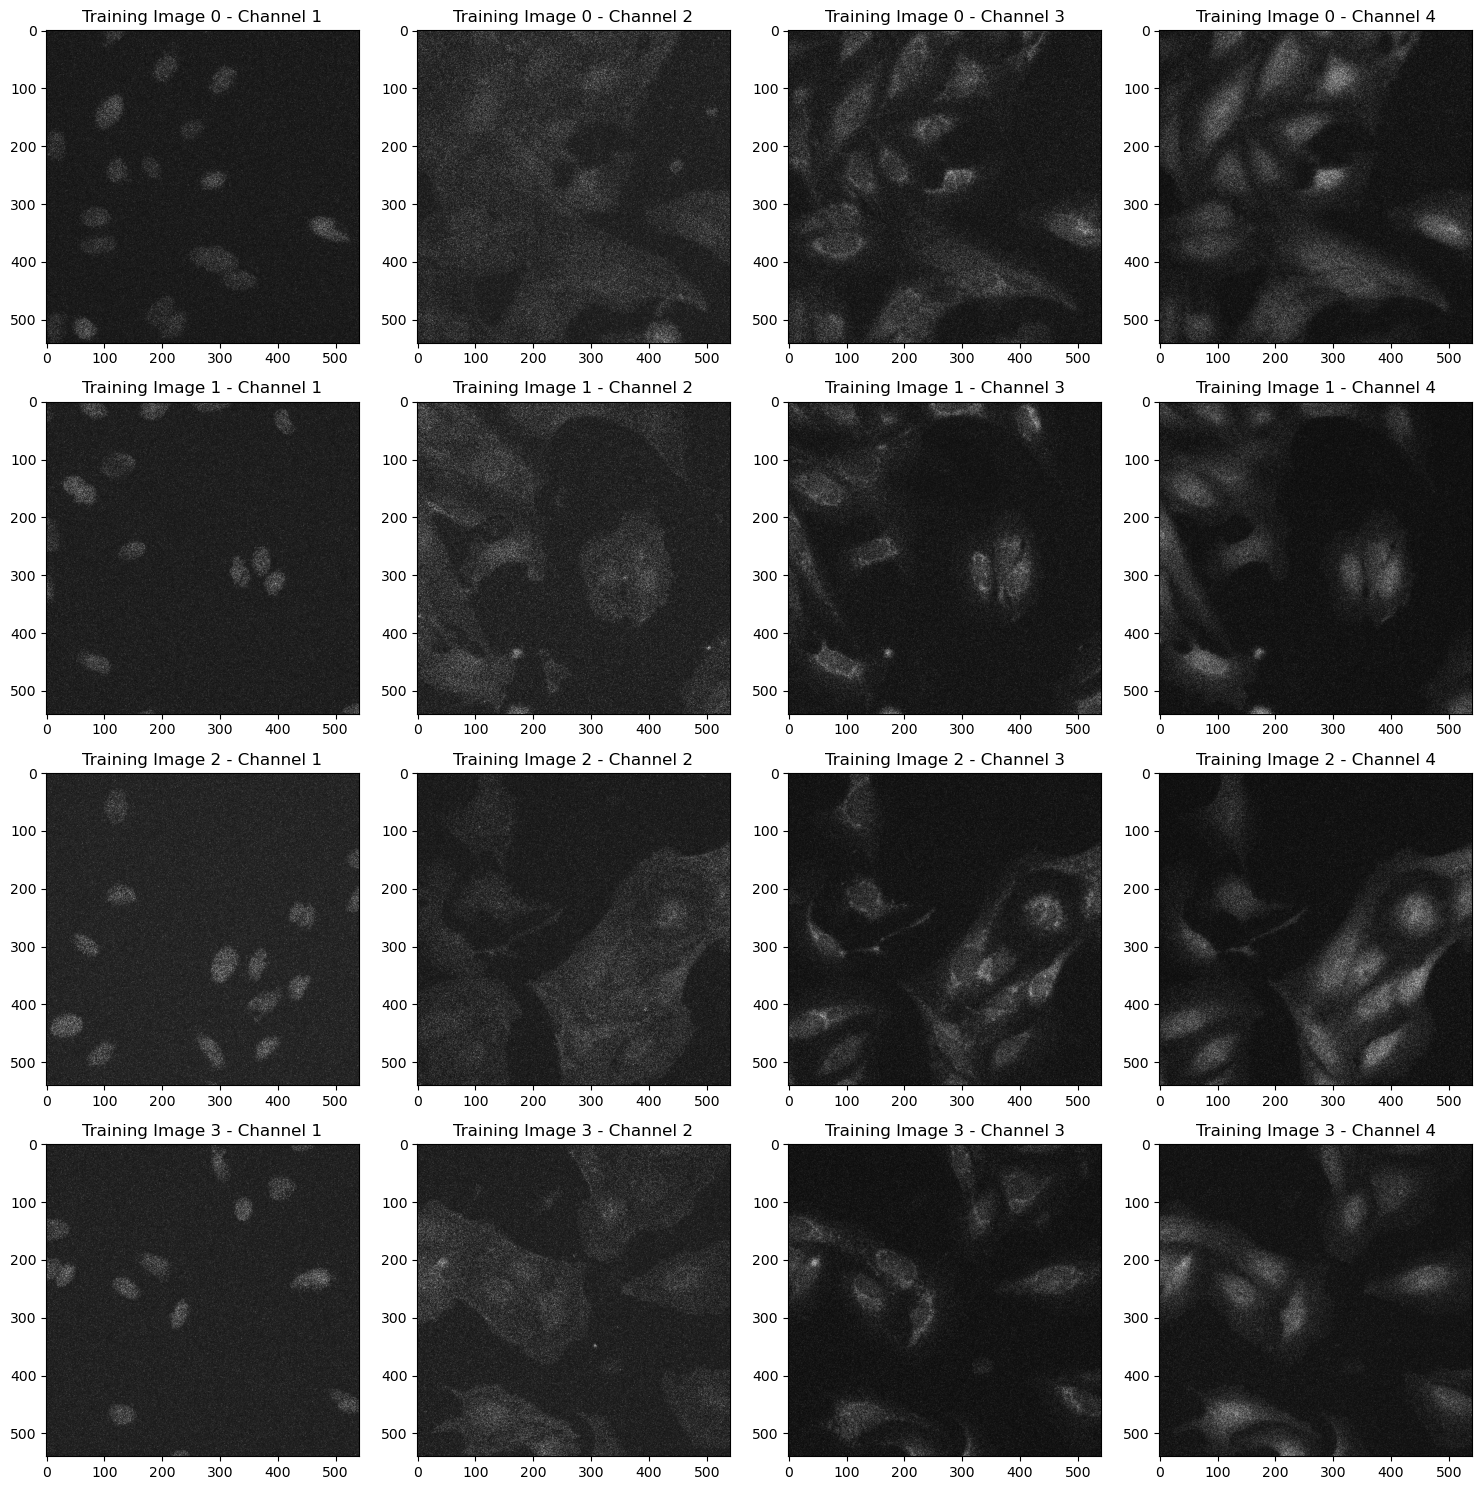

In [3]:
train_images = tifffile.imread("notebooks/data/jump/noisy_train.tiff")
val_images = tifffile.imread("notebooks/data/jump/noisy_val.tiff")

starting_index = 0 #Change this to show different images

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for idx in range(starting_index, starting_index + 4): #Couples the axes with the indexes
    for ax, ch in zip(axes[idx].flat, range(4)):
        ax.imshow(train_images[idx][ch], cmap="gray")
        ax.set_title(f"Training Image {idx} - Channel {ch+1}")
    
plt.tight_layout()


## Create the Training Configuration

Prima di procedere all'addestramento della Rete, occorre creare un oggetto di Configurazione dell'addestramento e della Rete che si desidera utilizzare.

I parametri più rilevanti per l'addestramento sono:
* ```batch_size```
* ```num_epochs```

Aggiustare il valore di questi parametri coerentemente alle caratteristiche dell'hardware su cui si intende svolgere l'addestramento.

In [4]:
config = create_n2v_configuration(
    experiment_name="jump_cells_n2v",
    data_type="array",
    axes="SCYX",
    n_channels=4,
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=1,
    independent_channels=True,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 4,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 4},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SCYX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
   

## Train the Model

L'addestramento del Modello avviene creando un oggetto CAREamist a partire dall'oggetto di Configurazione creato precedentemente.  
Il metodo .train del Modello richiede semplicemente che vengano fornite le immagini di Training e Validation.

Durante il training è possibile osservare alcuni parametri che ne descrivono l'andamento.

Al termine dell'addestramento vengono salvati gli Stati migliori del Modello in appositi file, segnalati con estensione .ckpt (Checkpoint).  

In [6]:
# Before proceding, make sure your GPU is available to PyTorch or the training will be very slow

careamist = CAREamist(source=config, work_dir="notebooks/models/jump")

# train model
print(f"Training starting now...")
careamist.train(train_source=train_images, val_source=val_images)
print("Training ended!")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training starting now...


Computed dataset mean: [0.20032482 0.46400058 0.6643161  0.94760716], std: [0.6120739  0.81329185 1.0557251  1.490119  ]
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /mnt/c/Users/Filippo Corti/Documents/GitHub/PrincipiEModelliDellaPercezione/notebooks/models/jump/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 2.0 M  | train
---------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.147     Total estimated model params size (MB)


Sanity Checking: |                                                                                | 0/? [00:00<?, ?it/s]

/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected


Epoch 0: 100%|███████| 1046/1046 [06:30<00:00,  2.68it/s, train_loss_step=0.705, val_loss=0.679, train_loss_epoch=0.687]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|███████| 1046/1046 [06:31<00:00,  2.67it/s, train_loss_step=0.705, val_loss=0.679, train_loss_epoch=0.687]
Training ended!


## Generate Predictions

Terminato l'addestramento, osserviamo il comportamento del Modello chiedendogli di predire le Immagini Pulite per alcuni campioni rumorosi.  
Tipicamente sarebbe più opportuno testare il Modello su dati diversi da quelli con cui viene addestrato, tuttavia nel caso specifico dell'Algoritmo N2V questa precauzione non è necessaria, poiché l'Algoritmo non ha comnuque mai avuto modo di imparare dalle Ground Truth di queste immagini.

Tramite il metodo .predict del Modello utilizziamo l'ultimo Checkpoint disponibile per predirre le prime 10 immagini del Dataset.  
Queste immagini vengono opportunamente salvate in memoria, in formato .TIFF.

In [7]:

output_path = "notebooks/predictions/jump/predictions.tiff"
predict_counter = 10 # The number of images we want to predict

predictions = []
for i in range(predict_counter):
    print(f"Predicting batch number {i}")
    pred_batch = careamist.predict(source=train_images[i], data_type='array', axes='CYX')
    predictions.append(pred_batch)

predictions = np.concatenate(predictions, axis=0).squeeze()
os.makedirs(os.path.dirname(output_path), exist_ok=True)
tifffile.imwrite(output_path, predictions)
print(f"TIFF file saved to {output_path}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pippo/anaconda3/envs/n2v/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting batch number 0
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.95it/s]
Predicting batch number 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.96it/s]
Predicting batch number 5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 6
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 7
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 8
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting batch number 9
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]
TIFF file saved to notebooks/predictions/jump/predictions.tiff


## Visualize the Predictions

A questo punto non resta che mostrare il risultato delle predizioni del Modello.

Per semplicità viene mostrata solamente la prima immagine, in ognuno dei suoi 4 canali.  
Vengono inoltre messe a confronto le predizioni ottenute con ```num_epochs=1``` e ```num_epochs=100```, qualora queste ultime fossero disponibili.

Le immagini sono una buona rappresentazione delle capacità dell'Algoritmo N2V quanto dei suoi limiti empirici.

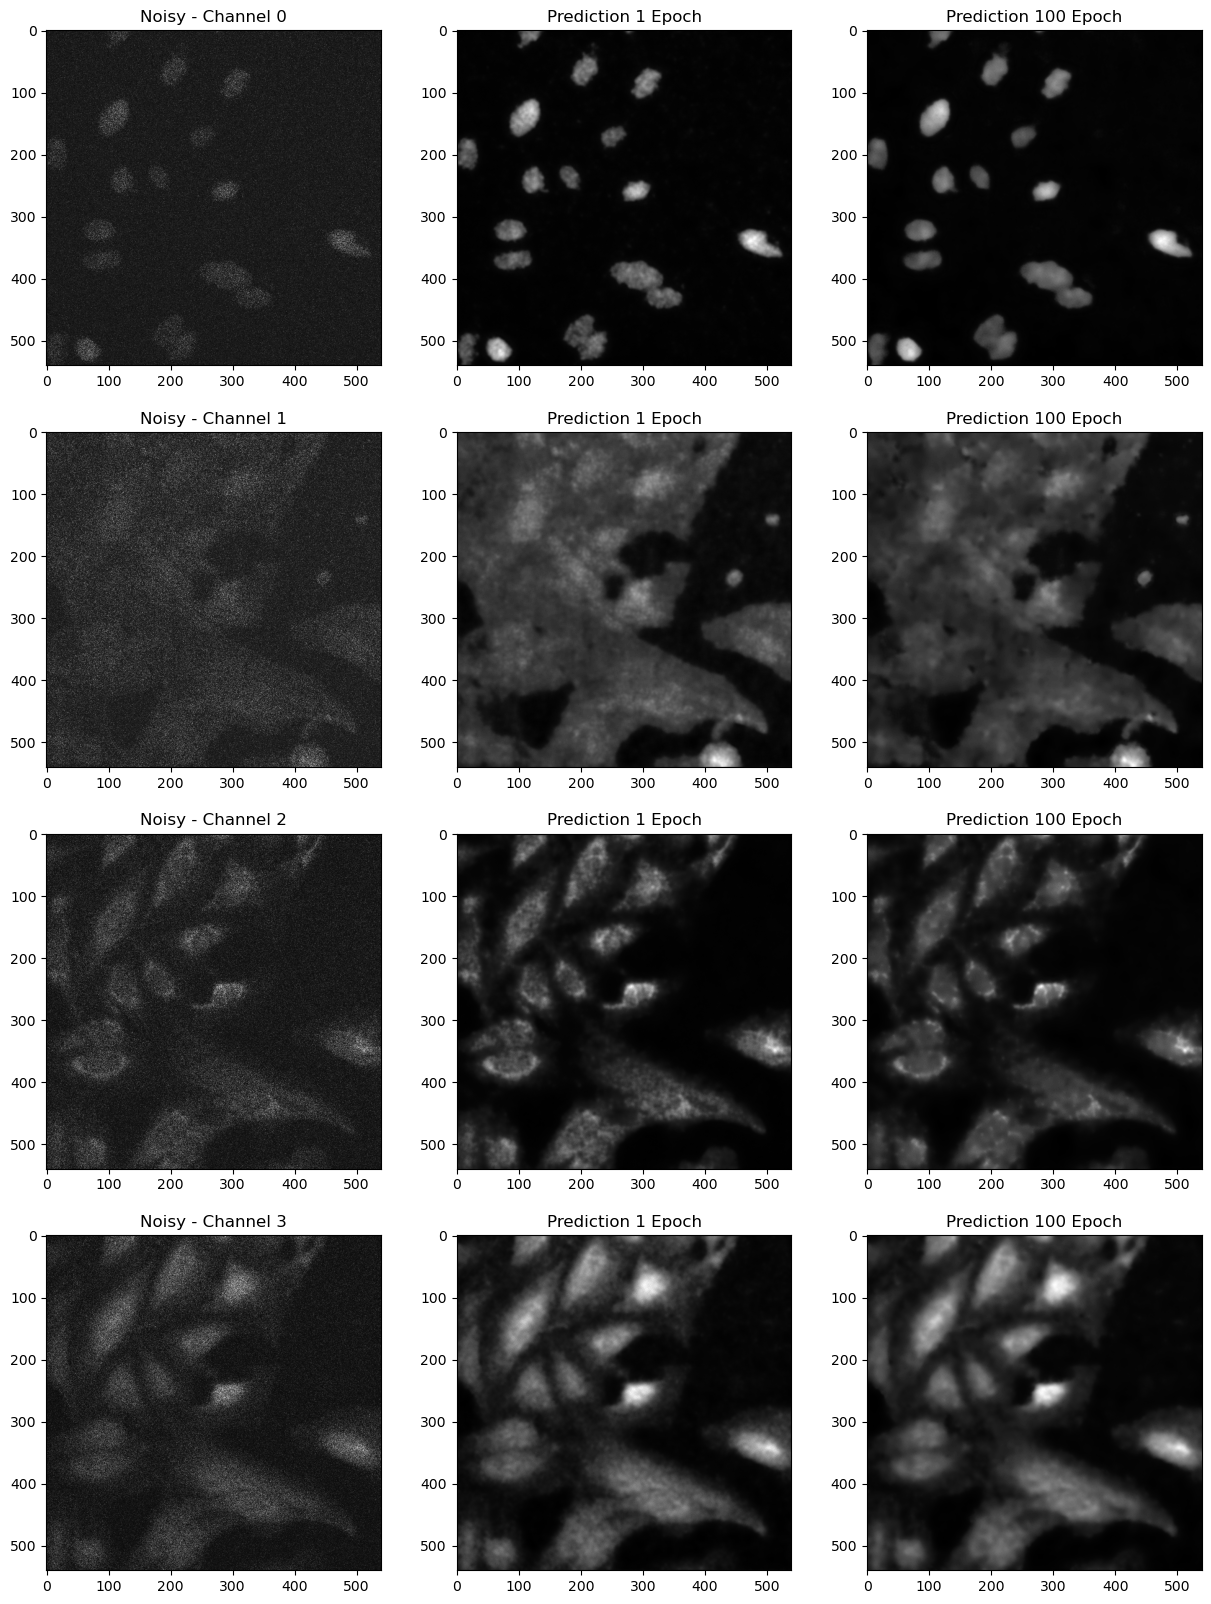

In [8]:

better_predictions_path = "notebooks/predictions/jump/predictions100.tiff"
if os.path.exists(better_predictions_path):
    better_predictions = tifffile.imread(better_predictions_path)
else:
    better_predictions = None

fig, ax = plt.subplots(4, 3 if better_predictions is not None else 2, figsize=(15, 20))
for i in range(4):
    ax[i, 0].imshow(train_images[0, i], cmap="gray")
    ax[i, 0].set_title(f"Noisy - Channel {i}")
    ax[i, 1].imshow(predictions[0].squeeze()[i], cmap="gray")
    ax[i, 1].set_title("Prediction 1 Epoch")
    if (better_predictions is not None):
        ax[i, 2].imshow(better_predictions[0].squeeze()[i], cmap="gray")
        ax[i, 2].set_title("Prediction 100 Epoch")
